# Summarizing Topic Models with Transformers

This kernel uses preprocessed data from [my earlier kernel](https://www.kaggle.com/donkeys/my-little-preprocessing). First, explore a bit of topic model parameters space, use the parameters to build matching topic models using [Gensim LDA](https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html), finds the most representative documents for each topic, and summarizes those documents using [HuggingFace Transformers](https://github.com/huggingface/transformers). The idea was to look at possibility of summarizing topic models based on large sets of text, and whether reasonable topic models can be found, ...

### Version History
- v11 update preprocessing with April 17th set, fixed filepath indices, fix other minor issues 
- v10 updated preprocessing
- v8 updated preprocessing
- v4-5 update to new preprocessing, pmc docs
- v3 clean up tokens from a few excess words id'd in v2, summarize top 3 / topic as one set for topic
- v2 first public version. find topic count using coherence values, describe top 20 words/tokens per topic, and top 3 documents per topic, summarize the top 3 / topic using transformers


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import logging

import os


TQDM for progress bars in notebooks:

In [2]:
from tqdm.auto import tqdm
tqdm.pandas()

In [3]:
!ls /kaggle/input/

CORD-19-research-challenge  covid-nlp-preprocess  my-little-preprocessing


In [4]:
!ls /kaggle/input/CORD-19-research-challenge/comm_use_subset/comm_use_subset/pdf_json | head -n 10

000b7d1517ceebb34e1e3e817695b6de03e2fa78.json
00142f93c18b07350be89e96372d240372437ed9.json
0022796bb2112abd2e6423ba2d57751db06049fb.json
0031e47b76374e05a18c266bd1a1140e5eacb54f.json
00326efcca0852dc6e39dc6b7786267e1bc4f194.json
00352a58c8766861effed18a4b079d1683fec2ec.json
0043d044273b8eb1585d3a66061e9b4e03edc062.json
0049ba8861864506e1e8559e7815f4de8b03dbed.json
00623bf2715e25d3acacb3f210d6888ed840e3cb.json
0072159e1ebecc889e9bcabb58bb45c47e18a403.json
ls: write error: Broken pipe


In [5]:
#!head /kaggle/input/CORD-19-research-challenge/comm_use_subset/comm_use_subset/pdf_json/00623bf2715e25d3acacb3f210d6888ed840e3cb.json -n 200

# Read in the Data

I am using a preprocessed dataset generated by my [other notebook](https://www.kaggle.com/donkeys/preprocess-input-docs-from-apr-17-upload-dataset), and uploaded as a [dataset](). This avoids some [memory issues](https://www.kaggle.com/general/142462#803723) that seem occut on Kaggle when using notebook outputs directly as inputs. This dataset has directories for "paragraphs" and "whole" documents. The first one hosts all docs split into paragraphs according to the original inputs. The second one has combined each document into one whole text file per document.

In [6]:
!ls /kaggle/input/covid-nlp-preprocess/output

closest.txt  paragraphs  unknown.txt  whole


In [7]:
!ls /kaggle/input/covid-nlp-preprocess/output/paragraphs

biorxiv_medrxiv  comm_use_subset  custom_license  noncomm_use_subset


The above shows two .txt files, and four directories under both paragraphs and whole dirs. The directories match those in the Kaggle input dataset for documents. Just the contents have been preprocessed to remove stopwords, lemmatize, clean up a bit. The .txt files contain a set of unrecognized words and their closest identified matching identified words. So one could update the preprocessor if there is a frequent typo, or similar, in the dataset documents.

Anyway, for this kernel the important bits are in the four directories / folders. The preprocessed documents.

Again, as in preprocessing, I use a simple data structure to hold the different forms of the text in each doc:

In [8]:
class COVDoc:
    def __init__(self):
        self.filepath_proc = None
        self.filepath_orig = None
        #self.basepath_orig = None
        #self.text_proc = None
        self.text_orig = None
        self.abstract = None
        self.tokenized_proc = None
        self.doc_type = None
    
    #this function allows me to lazy-load the original text to save memory
    def load_orig(self):
        with open(self.filepath_orig) as f:
            d = json.load(f)
            body = ""
            for idx, paragraph in enumerate(d["body_text"]):
                body += f"{paragraph['text']}\n"
            self.text_orig = body

    def load_abstract(self):
        with open(self.filepath_orig) as f:
            d = json.load(f)
            if "abstract" in d:
                abstract_list = d["abstract"]
                if len(abstract_list) > 0:
                    self.abstract = d["abstract"][0]["text"]


Function to load different datasets into memory, matching the preprocessed texts to their original files:

In [9]:
import glob, os, json

def load_docs(base_path, base_path_orig, doc_type):
    loaded_docs = []
    file_paths_proc = glob.glob(base_path)
    file_names_proc = [os.path.basename(path) for path in file_paths_proc]
    file_names_orig = [os.path.splitext(filename)[0]+".json" for filename in file_names_proc]
    #file_paths_orig = [os.path.join(base_path_orig, filename) for filename in file_names_orig]
    for idx, filepath_proc in enumerate(file_paths_proc):
        doc = COVDoc()
        doc.doc_type = doc_type
        #doc.basepath_orig = base_path_orig
        doc.filepath_proc = filepath_proc
        filename = file_names_orig[idx]
        if filename.startswith("PMC"):
            filepath = os.path.join(base_path_orig, "pmc_json", filename)
        else:
            filepath = os.path.join(base_path_orig, "pdf_json", filename)
        doc.filepath_orig = filepath
        with open(filepath_proc) as f:
            d = f.read()
            doc.tokenized_proc = d.strip().split(" ")
            if len(doc.tokenized_proc) < 2:
                print("skipping doc due to no content:"+filepath_proc)
                continue
            if "PMC2114261" in filename:
                print(doc.filepath_proc)
                print(doc.filepath_orig)
            doc.tokenized_proc = [token for token in doc.tokenized_proc if (token != "et" and token != "al" and token != "fig") ]
        loaded_docs.append(doc)
    return loaded_docs

## The Four Datasets

In [10]:
!ls /kaggle/input/CORD-19-research-challenge/biorxiv_medrxiv/biorxiv_medrxiv


pdf_json


In [11]:
!ls /kaggle/input/covid-nlp-preprocess/output/whole

biorxiv_medrxiv  comm_use_subset  custom_license  noncomm_use_subset


Load all four datasets in preprocessed form, and capture reference to original, non-processed file:

In [12]:
med_docs = load_docs("/kaggle/input/covid-nlp-preprocess/output/whole/biorxiv_medrxiv/*.txt", "/kaggle/input/CORD-19-research-challenge/biorxiv_medrxiv/biorxiv_medrxiv", "medx")
len(med_docs)

1794

In [13]:
comuse_docs = load_docs("/kaggle/input/covid-nlp-preprocess/output/whole/comm_use_subset/*.txt", "/kaggle/input/CORD-19-research-challenge/comm_use_subset/comm_use_subset", "comm_user")
len(comuse_docs)

8550

In [14]:
noncom_docs = load_docs("/kaggle/input/covid-nlp-preprocess/output/whole/noncomm_use_subset/*.txt", "/kaggle/input/CORD-19-research-challenge/noncomm_use_subset/noncomm_use_subset", "noncomm")
len(noncom_docs)

2052

In [15]:
custom_docs = load_docs("/kaggle/input/covid-nlp-preprocess/output/whole/custom_license/*.txt", "/kaggle/input/CORD-19-research-challenge/custom_license/custom_license", "custom")
len(custom_docs)

23531

In [16]:
#!cat /kaggle/input/CORD-19-research-challenge/noncomm_use_subset/noncomm_use_subset/pmc_json/PMC5632742.xml.json
#!cat /kaggle/input/CORD-19-research-challenge/custom_license/custom_license/pdf_json/94f6c2e70e777539702580b3afc0c2d45a4d57b0.json

In [17]:
#!ls kaggle/input/CORD-19-research-challenge/biorxiv_medrxiv/biorxiv_medrxiv/pdf_orig

# Gensim Processing and LDA Topic Modelling

Collect all four datasets into one, and convert the documents into Gensim consumable format:

In [18]:
#https://www.machinelearningplus.com/nlp/gensim-tutorial/
from gensim.models import LdaModel, LdaMulticore
from gensim import corpora

all_docs = med_docs
all_docs.extend(comuse_docs)
all_docs.extend(noncom_docs)
all_docs.extend(custom_docs)

doc_tokens = [doc.tokenized_proc for doc in all_docs]

#id to word mapping for gensim
id2word = corpora.Dictionary(doc_tokens)

In [19]:
corpus = [id2word.doc2bow(text) for text in doc_tokens] 

We are short on memory again, so clear everything when can:

In [20]:
del doc_tokens

## Gensim (Hyper)Parameter Search

Uncomment the cell below to enable Gensim logging to console. This shows at what point the topics start to converge, and how much they converge. So I found with 2 passes and about 250+ iterations they seemed to converge quite well (around 90%). So I went with that.. Just disabled this for public kernel because it produces a lot of spammy text.

In [21]:
#https://stackoverflow.com/questions/7016056/python-logging-not-outputting-anything
#for handler in logging.root.handlers[:]:
#    logging.root.removeHandler(handler)
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)


If you like to play with a small, single instance model, try uncommenting below and play with the parameters.

In [22]:
#test_lda = LdaMulticore(corpus,num_topics=2, id2word=id2word, iterations=500, passes=2) 
#sentence = 'i like red wine with steak'
#sentence2 = [word for word in sentence.lower().split()] 
#test_lda[id2word.doc2bow(sentence2)]

### Most Coherent Topics

Gensim has a notion of [Topic Coherence](https://rare-technologies.com/what-is-topic-coherence/). The higher the coherence value, the better the topics should be. So I tried some different values to pick the best one (according to the coherence measure):

In [23]:
from gensim.models import CoherenceModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3): 
    """
    Compute c_v coherence for various number of topics
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respect """
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word, iterations=600, passes=2) 
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
#        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

This experiments with topic models of different sizes to see what kind of coherence it gives. The model with highest coherence is then used later. This loop here for now just runs a few different values, although I tried more earlier:

In [24]:
topic_count_start = 3
topic_count_step = 1
topic_count_limit = 10
# Can take a long time to run.
model_list, coherence_values = \
  compute_coherence_values(dictionary=id2word, corpus=corpus, texts=None, limit=topic_count_limit, start=topic_count_start, step=topic_count_step)
#  compute_coherence_values(dictionary=id2word, corpus=corpus, texts=doc_tokens, limit=topic_count_limit, start=topic_count_start, step=topic_count_step)


Print and visualize the coherence results for the different model configurations:

In [25]:
coherence_values

[-0.43305445168932516,
 -0.3849844401198839,
 -0.48514812294305665,
 -0.5275248568059149,
 -0.48592862445163393,
 -0.53146229810077,
 -0.5347635628017253]

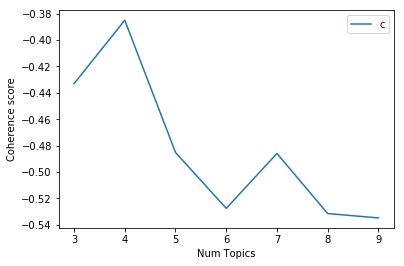

In [26]:
import matplotlib.pyplot as plt 
%matplotlib inline
# Show graph
x = range(topic_count_start, topic_count_limit, topic_count_step)
plt.plot(x, coherence_values) 
plt.xlabel("Num Topics") 
plt.ylabel("Coherence score") 
plt.legend(("coherence_values"), loc='best') 
plt.show()

Find the model with highest coherence:

In [27]:
topic_idx = np.argmax(coherence_values)
print(coherence_values[topic_idx]) 
test_lda = model_list[topic_idx]


-0.3849844401198839


## Final Topic Models

How many topics did we end up with choosing?

In [28]:
test_lda.num_topics

4

Which model was it in the list of tried models?

In [29]:
topic_idx

1

Visualize the topics in terms of their top words (words giving highest importance in the specific topic):

In [30]:
n_topics = test_lda.num_topics
col_names = []
for x in range(n_topics):
    topic_name = f"Topic{x+1}"
    col_names.append((topic_name, "Word"))
    col_names.append((topic_name, "Weight"))
     

In [31]:
tw_df = pd.DataFrame()

In [32]:
data = []
for x in range(n_topics):
    top_words = test_lda.show_topic(x, 20)
    words = []
    weights = []
    for word_weight in top_words:
        words.append(word_weight[0])
        weights.append(word_weight[1])
    data.append(words)
    data.append(weights)
    tw_df[f"Word{x+1}"] = words
    tw_df[f"Weight{x+1}"] = weights   

In [33]:
tw_df.columns = pd.MultiIndex.from_tuples(col_names)

In [34]:
tw_df

Topic1               Topic2               Topic3            \
           Word    Weight       Word    Weight       Word    Weight   
0       patient  0.009526       cell  0.015087        use  0.012650   
1       disease  0.007413        use  0.009347      virus  0.010543   
2     infection  0.007116      virus  0.007801    protein  0.008601   
3           use  0.006772      mouse  0.007667       cell  0.008042   
4         study  0.006423  infection  0.007326   sequence  0.006869   
5          case  0.005430      model  0.006440        rna  0.005886   
6         virus  0.005061      study  0.004754       gene  0.005148   
7        health  0.004445    disease  0.004226    vaccine  0.005138   
8      clinical  0.003151   response  0.004126   antibody  0.004944   
9          risk  0.003073       time  0.003539      study  0.004859   
10          day  0.002965     result  0.003461      viral  0.004747   
11       result  0.002938     number  0.003165     strain  0.004744   
12         data  0.002905      group  0.003101     sample  0.004582   
13        group  0.002709       data  0.003063  infection  0.004059   
14    treatment  0.002703      viral  0.003056      human  0.004037   
15         time  0.002624     effect  0.002900     genome  0.003333   
16        human  0.002602     system  0.002867        dna  0.003296   
17         year  0.002552        day  0.002765     result  0.003267   
18  respiratory  0.002516   infected  0.002707      assay  0.003126   
19       number  0.002505    control  0.002697      group  0.002978   

         Topic4            
           Word    Weight  
0          cell  0.021977  
1       protein  0.013071  
2         virus  0.009813  
3           use  0.007297  
4         viral  0.005643  
5     infection  0.005241  
6          gene  0.004717  
7    expression  0.004504  
8      activity  0.004435  
9         study  0.004071  
10     membrane  0.003268  
11       effect  0.003009  
12        human  0.002967  
13        level  0.002887  
14       result  0.002860  
15          rna  0.002843  
16        shown  0.002636  
17  replication  0.002534  
18    structure  0.002524  
19      binding  0.002510

The details of the topics change a bit over runs due to random init state and similar factors. So cannot comment on exact detail as it might change on notebook run. But on a general level the topics seem to describe patient studies, patients in general, viruses, trials. Depending on how many we take. It seems that up to about 5 topics the set can be seen as providing quite coherent topics that are quite identifiable with some "concept".

# Find Top Documents/Articles for Topics

LDA Topic Models represent assignments of words in documents to different topics. Find the documents that are assigned most into each topic. Assume that those documents best represent that topic:

In [35]:
import heapq 

top_docs = {} 
#first create placeholder lists for top 3 docs in each topic 
for t in range(0, n_topics):
    doc_list = [(-1,-1),(-1,-1),(-1,-1)] 
    heapq.heapify(doc_list)
    top_docs[t] = doc_list
#count variable in following is practically doc_id since the index is from 0 with increments of 1
count = 0
for doc in tqdm(corpus):
    topics = test_lda[doc] 
    for topic_prob in topics:
        topic_n = topic_prob[0]
        topic_p = topic_prob[1]
        top_list = top_docs[topic_n]
        #count is document id, heapq sorts by first item in tuple
        heapq.heappushpop(top_list, (topic_p, count))
        #above pushes new item, pops lowest item. so pop itself if lowest..
    count += 1

In [36]:
#print(top_docs)

In [37]:
top_sorted = {}
for topic_id in top_docs:
    heap = top_docs[topic_id]
    sorted_topics = [heapq.heappop(heap) for _ in range(len(heap))] 
    print(str(topic_id)+": "+str(sorted_topics)) 
    top_sorted[topic_id] = sorted_topics


0: [(0.9999937, 29928), (0.9999975, 15289), (0.999998, 3957)]
1: [(0.99994415, 20540), (0.9999589, 4030), (0.9999714, 26174)]
2: [(0.9998744, 7773), (0.999901, 12216), (0.99990326, 28606)]
3: [(0.9999462, 29283), (0.9999542, 25129), (0.9999641, 21570)]


In [38]:
topic_names = [f"Topic{x+1}" for x in range(n_topics)]
word_names = [f"Word{x+1}" for x in range(3)]

top_doc_weights = []
top_doc_paths = []

pd.options.display.max_colwidth = 100

for topic_id in top_sorted:
    top_docs = top_sorted[topic_id]
    doc_ids = [doc_tuple[1] for doc_tuple in top_sorted[topic_id]] 
    doc_weights = [doc_tuple[0] for doc_tuple in top_sorted[topic_id]]
    topic_docs = [all_docs[doc_id] for doc_id in doc_ids]
    for x in range(3):
        doc = topic_docs[x]
        doc_path = f"{doc.doc_type}/{os.path.basename(doc.filepath_orig)}"
        weight = doc_weights[x]
        top_doc_weights.append(weight)
        top_doc_paths.append(doc_path)
top_doc_weights.reverse()
top_doc_paths.reverse()


In [39]:
df = pd.DataFrame()
df["weight"] = top_doc_weights
df["path"] = top_doc_paths
df.index = pd.MultiIndex.from_product([topic_names,
                                     ['Doc1', 'Doc2', 'Doc3']],
                                    names=['',''])
df

weight                                                     path
                                                                              
Topic1 Doc1  0.999964     custom/87cf607958cf578fc1fe109d72696602b073982f.json
       Doc2  0.999954     custom/b9197522c6f6c8b536e91e67389e0a1b7c8d59be.json
       Doc3  0.999946                               custom/PMC4095937.xml.json
Topic2 Doc1  0.999903     custom/a895a62ae026cc856f9f68c1e3bf139295714ac8.json
       Doc2  0.999901    noncomm/9b3127bf657a3117c2c1f4543e01ee068a9fb0bf.json
       Doc3  0.999874                            comm_user/PMC4493287.xml.json
Topic3 Doc1  0.999971     custom/60bb51055d46a0cbed05cd0bcbfc6b8edd8b97af.json
       Doc2  0.999959  comm_user/7a31934a646fe1bb3400d2718b13661b999cad56.json
       Doc3  0.999944     custom/6525a96d803e7e9f3c33171c1e2b12dd8752411c.json
Topic4 Doc1  0.999998                            comm_user/PMC4429500.xml.json
       Doc2  0.999997                               custom/PMC3654146.xml.json
       Doc3  0.999994                               custom/PMC2816237.xml.json

# Summarize with Transformers

In [40]:
for topic_id in top_sorted:
    print()
    print()
    print(f"----------- TOPIC {topic_id}: -----------")
    top_docs = top_sorted[topic_id]
    doc_ids = [doc_tuple[1] for doc_tuple in top_sorted[topic_id]] 
    doc_weights = [doc_tuple[0] for doc_tuple in top_sorted[topic_id]]
    topic_docs = [all_docs[doc_id] for doc_id in doc_ids]
    for x in range(3):
        print(f"----------- TOPIC {topic_id} / doc {x+1}: -----------")
        doc = topic_docs[x]
        doc.load_abstract()
        doc.load_orig()
        if doc.abstract != None:
            print(doc.abstract)
        else:
            print(doc.text_orig[:400])




----------- TOPIC 0: -----------
----------- TOPIC 0 / doc 1: -----------

Wednesday


August 4, 2010


WORKSHOPS

W101
9:00 AM-11:30 AM
CROSS CULTURAL RESEARCH IN HEALTH PROMOTION AND CHRONIC DISEASE MANAGEMENT
Edwin B. Fisher, PhD,1,2 Brian Oldenburg,3 Renée I. Boothroyd,1,2 Carina K. Chan4 and Marisa Finn5

1Peers for Progress, American Academy of Family Physicians Foundation, Leawood, KS; 2Health Behavior & Health Education, University of North Carolina at Chapel Hi
----------- TOPIC 0 / doc 2: -----------
ABSTRACTS OF SUBMISSIONS
ACCEPTED FOR PRESENTATION
“MY CLIENTS FALL THROUGH EVERY CRACK IN THE SYSTEM”: ASSESSING THE NEED FOR GERIATRICS HEALTH TRAINING AMONG LEGAL PROFESSIONALS Tacara N. Soones1; Cyrus Ahalt2; Sarah Garrigues2; David Faigman3; Brie Williams2. 1University of California- San Francisco, San Francisco, CA; 2University of California-San Francisco, San Francisco, CA; 3UCSF/UC Hasting
----------- TOPIC 0 / doc 3: -----------


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/CORD-19-research-challenge/comm_use_subset/comm_use_subset/pmc_json/PMC4429500.xml.json'

Install the transformer libs:

In [41]:
!pip install --upgrade transformers

     |████████████████████████████████| 563 kB 4.4 MB/s 
  Attempting uninstall: transformers
    Found existing installation: transformers 2.5.1
    Uninstalling transformers-2.5.1:
      Successfully uninstalled transformers-2.5.1


In [42]:
from transformers import pipeline

Thanks for the great libs HuggingFacers! Straight out of the HuggingFace examples:

In [43]:
summarizer = pipeline('summarization')
#summarizer(TEXT_TO_SUMMARIZE)

The following summarizes the 3 top documents per topic. These are the same ones I printed the beginning for earlier above. So perhaps compare the above short snippets (potential abstracts) to what summary the transformer provides:

In [44]:
for topic_id in top_sorted:
    print()
    print()
    print(f"----------- TOPIC {topic_id}: -----------")
    top_docs = top_sorted[topic_id]
    doc_ids = [doc_tuple[1] for doc_tuple in top_sorted[topic_id]] 
    doc_weights = [doc_tuple[0] for doc_tuple in top_sorted[topic_id]]
    topic_docs = [all_docs[doc_id] for doc_id in doc_ids]
    for x in range(3):
        print(f"----------- TOPIC {topic_id} / doc {x+1}: -----------")
        doc = topic_docs[x]
        doc.load_orig()
        weight = doc_weights[x]
        print(f"topic %:{weight}, document:{doc.filepath_orig}")
        #and this is the magic line doing the summary
        print(summarizer(doc.text_orig, min_length=200, max_length=400))



----------- TOPIC 0: -----------
----------- TOPIC 0 / doc 1: -----------
topic %:0.9999936819076538, document:/kaggle/input/CORD-19-research-challenge/custom_license/custom_license/pmc_json/PMC2816237.xml.json
[{'summary_text': '1Peers for Progress, American Academy of Family Physicians Foundation, Leawood, KS. 2Health Behavior & Health Education, University of North Carolina at Chapel Hill, Chapel Hill. 3School of Public Health & Preventive Medicine, Monash University, Melbourne, VIC, Australia. 4Tan Sri Jeffrey Cheah School of Medicine,Monash University (Sunway Campus), Selangor Darul Ehsan, Malaysia. 5Department of Psychology, The University of Auckland, Tamaki Campus, Auckland, New Zealand. 6. How you can create INTERNET DELIVERED HEALTH BEHAVIOUR CHANGE INTERVENTIONS USING THE LIFEGUIDE. 7. The power of EXPECTATIONS: About PLACEBO and NOCEBO EFFECTS. 8. How to use the Internet to help people with disabilities. 9. How do you use the internet to help you with your health care dec

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/CORD-19-research-challenge/comm_use_subset/comm_use_subset/pmc_json/PMC4429500.xml.json'

And as another viewpoint, try to summarize all top 3 documents in one for each topic:

In [45]:
for topic_id in top_sorted:
    print()
    print()
    print(f"----------- TOPIC {topic_id}: -----------")
    top_docs = top_sorted[topic_id]
    doc_ids = [doc_tuple[1] for doc_tuple in top_sorted[topic_id]] 
    doc_weights = [doc_tuple[0] for doc_tuple in top_sorted[topic_id]]
    topic_docs = [all_docs[doc_id] for doc_id in doc_ids]
    combined_text = ""
    for x in range(3):
        print(f"----------- TOPIC {topic_id} / doc {x+1}: -----------")
        doc = topic_docs[x]
        doc.load_orig()
        weight = doc_weights[x]
        print(f"topic %:{weight}, document:{doc.filepath_orig}")
        combined_text += " "+doc.text_orig
        #and this is the magic line doing the summary
    print(summarizer(combined_text, min_length=500, max_length=1000))



----------- TOPIC 0: -----------
----------- TOPIC 0 / doc 1: -----------
topic %:0.9999936819076538, document:/kaggle/input/CORD-19-research-challenge/custom_license/custom_license/pmc_json/PMC2816237.xml.json
----------- TOPIC 0 / doc 2: -----------
topic %:0.9999974966049194, document:/kaggle/input/CORD-19-research-challenge/custom_license/custom_license/pmc_json/PMC3654146.xml.json
----------- TOPIC 0 / doc 3: -----------


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/CORD-19-research-challenge/comm_use_subset/comm_use_subset/pmc_json/PMC4429500.xml.json'

### Final Thoughts

Well, I thought this was interesting.

Sometimes it looks like there are some issues with how the transformer summarizes longer texts. Most of the time it seems to pick a specific "topic" (no pun intended..:) and just write a piece on that. Great looking for automated generation though.

And that's all folks. Not sure how useful it is for actual COVID research but it was an interesting start (for me) on the COVID docs..